# Result Prediction

In [1]:
import pandas as pd
import numpy as np

from Helper_Functions.sampling_functions import *
from Helper_Functions.Backwards_Feature_Selection import stepwise_selection_classification
from Helper_Functions.ForwardsStepwiseSelection import ForwardsStepwiseSelection

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
X, y = pd.read_csv('Data/Diff_train.csv'), pd.read_csv('Train_Data/Y_train.csv', index_col=0)
y = y.loc[X.index] # This is our target

We will encode the y set, so that 

- -1: Loss
- 0: Draw
- 1: Win

In [3]:
mappings = {'AWAY_WINS' : -1, 'DRAW' : 0, 'HOME_WINS' : 1}
y = pd.from_dummies(y)[''].apply(lambda x : mappings[x])
y.head()

y = pd.DataFrame(y)
y.columns = ['RESULT']
y['RESULT']=y['RESULT'].astype('int')
y.head()

,RESULT
0,-1
1,0
2,-1
3,1
4,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Feature Selection

So, we now need to select the feature upon which we will train our model. At the moment, I am unsure what the best approach will be: do we predict WDL or just WL? I will therefore apply stepwise selection of both sets of data to figure out which are the best features to use (hopefully there will be some overlap). 

Before we do that, however, we will play the same trick as before: we create an upsampled data set.

In [5]:
y_train['RESULT'].value_counts()

RESULT
 1    3393
-1    2427
 0    2053
Name: count, dtype: int64

As we will want to predict WL and WLD, we will create seperate training sets. 

First we upsample the data

In [6]:
train_upsampled = get_fraction_of_data(get_upsampled_data(X_train, y_train), 4273, 'RESULT')
X_train_upsampled, y_train_upsampled = train_upsampled[X_train.columns], train_upsampled['RESULT']

y_train_upsampled = pd.DataFrame({'RESULT' : y_train_upsampled}).astype('int')

print(y_train_upsampled.value_counts())

RESULT
-1        4273
 0        4273
 1        4273
Name: count, dtype: int64


In [7]:
X_train_upsampled_WL = X_train_upsampled.loc[y_train_upsampled['RESULT'] != 0]
y_train_upsampled_WL = y_train_upsampled.loc[y_train_upsampled['RESULT'] != 0]
display(X_train_upsampled_WL.describe())
display(y_train_upsampled_WL.describe())

,HOME_TEAM_INJURIES_season_sum,HOME_TEAM_GAME_WON_season_sum,HOME_TEAM_GAME_DRAW_season_sum,HOME_TEAM_GAME_LOST_season_sum,HOME_TEAM_SHOTS_TOTAL_season_std,HOME_TEAM_SHOTS_INSIDEBOX_season_std,HOME_TEAM_SHOTS_OFF_TARGET_season_std,HOME_TEAM_SHOTS_ON_TARGET_season_std,HOME_TEAM_SHOTS_OUTSIDEBOX_season_std,HOME_TEAM_PASSES_season_std,...,DIFF_TEAM_GAME_LOST_5_last_match_sum,DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,DIFF_TEAM_BALL_POSSESSION_5_last_match_average,WIN_PRIOR,DRAW_PRIOR,LOST_PRIOR,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum,DIFF_FORM_5_last_match_sum,NORMAL_SAMPLED_PREDICTED_GD
count,8546.000000,8546.000000,8546.000000,8546.000000,8546.00000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,...,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000
mean,4.076602,4.129919,4.570056,4.705466,4.24221,4.177556,4.080857,3.858647,3.919182,4.173784,...,5.094179,4.964178,4.943424,1.090134,1.053475,1.165879,4.977241,4.969440,5.133307,4.261035
std,2.713046,2.909015,2.881131,2.939828,2.75892,2.600709,2.814971,2.765948,2.622784,2.615430,...,2.086682,1.908472,1.970463,1.218300,0.926247,1.247440,1.300554,1.290006,1.351971,1.552622
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486883,0.491021,0.254102,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.500000,3.500000,3.500000,0.204082,0.303030,0.238095,4.131519,4.135519,4.267009,3.232061
50%,4.153921,4.000000,5.000000,5.000000,4.00000,4.111977,4.000000,3.000000,3.899202,4.137461,...,5.000000,4.962532,5.000000,0.714286,0.887574,0.800000,4.981794,4.966223,5.103298,4.315183
75%,6.000000,6.000000,6.000000,7.000000,6.00000,6.000000,6.000000,6.000000,5.000000,6.000000,...,6.500000,6.000000,6.500000,1.600000,1.603850,1.666667,5.807654,5.773863,5.979164,5.211220
max,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,6.944444,10.000000,10.000000,10.000000,10.000000,10.000000


,RESULT
count,8546.000000
mean,0.000000
std,1.000059
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
X_train_WL = X_train.loc[y_train['RESULT'] != 0]
y_train_WL = y_train.loc[y_train['RESULT'] != 0]
display(X_train_upsampled_WL.describe())
display(y_train_upsampled_WL.describe())

,HOME_TEAM_INJURIES_season_sum,HOME_TEAM_GAME_WON_season_sum,HOME_TEAM_GAME_DRAW_season_sum,HOME_TEAM_GAME_LOST_season_sum,HOME_TEAM_SHOTS_TOTAL_season_std,HOME_TEAM_SHOTS_INSIDEBOX_season_std,HOME_TEAM_SHOTS_OFF_TARGET_season_std,HOME_TEAM_SHOTS_ON_TARGET_season_std,HOME_TEAM_SHOTS_OUTSIDEBOX_season_std,HOME_TEAM_PASSES_season_std,...,DIFF_TEAM_GAME_LOST_5_last_match_sum,DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,DIFF_TEAM_BALL_POSSESSION_5_last_match_average,WIN_PRIOR,DRAW_PRIOR,LOST_PRIOR,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum,DIFF_FORM_5_last_match_sum,NORMAL_SAMPLED_PREDICTED_GD
count,8546.000000,8546.000000,8546.000000,8546.000000,8546.00000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,...,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000,8546.000000
mean,4.076602,4.129919,4.570056,4.705466,4.24221,4.177556,4.080857,3.858647,3.919182,4.173784,...,5.094179,4.964178,4.943424,1.090134,1.053475,1.165879,4.977241,4.969440,5.133307,4.261035
std,2.713046,2.909015,2.881131,2.939828,2.75892,2.600709,2.814971,2.765948,2.622784,2.615430,...,2.086682,1.908472,1.970463,1.218300,0.926247,1.247440,1.300554,1.290006,1.351971,1.552622
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486883,0.491021,0.254102,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.500000,3.500000,3.500000,0.204082,0.303030,0.238095,4.131519,4.135519,4.267009,3.232061
50%,4.153921,4.000000,5.000000,5.000000,4.00000,4.111977,4.000000,3.000000,3.899202,4.137461,...,5.000000,4.962532,5.000000,0.714286,0.887574,0.800000,4.981794,4.966223,5.103298,4.315183
75%,6.000000,6.000000,6.000000,7.000000,6.00000,6.000000,6.000000,6.000000,5.000000,6.000000,...,6.500000,6.000000,6.500000,1.600000,1.603850,1.666667,5.807654,5.773863,5.979164,5.211220
max,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,6.944444,10.000000,10.000000,10.000000,10.000000,10.000000


,RESULT
count,8546.000000
mean,0.000000
std,1.000059
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


### Feature Selection with Wins & Losses

In [9]:
def stepwise_selection(p, model, X_train, y_train):
    '''Uses backwards selection to select the p best features'''
    selector = RFE(model, n_features_to_select=1)
    selector = selector.fit(X_train, y_train)
    
    lst = [(r, c) for r, c in zip(selector.ranking_, X_train.columns)]
    lst.sort(key = lambda x : x[0])
    
    return [x[1] for x in lst[:p]], selector.estimator_

In [10]:
def stepwise_selection_plotting(features, X_train, y_train, X_valid, y_valid, measure = accuracy_score, train_score_weight = 0.74):
    train_score, valid_score = [], []
    for p in range(len(features)):
        model = RidgeClassifier()
        model.fit(X_train[features[:p+1]], y_train)

        train_score.append(train_score_weight*measure(y_train, model.predict(X_train[features[:p+1]])))
        valid_score.append(measure(y_valid, model.predict(X_valid[features[:p+1]])))

    x = [f'{f}, {i}' for i, f in enumerate(features)]
    plt.plot(x, train_score, label = 'Training Score')
    plt.plot(x, valid_score, label = 'Validation Score')
    plt.ylabel('Score')    
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

Using these two functions we will obtain the most relevant features using a simiple linear classifier

In [11]:
# best_features_WL_upsampled, _ = stepwise_selection(30, RidgeClassifier(), X_train_upsampled_WL, y_train_upsampled_WL)
# stepwise_selection_plotting(best_features_WL_upsampled, X_train_upsampled_WL, y_train_upsampled_WL, X_valid, y_valid)

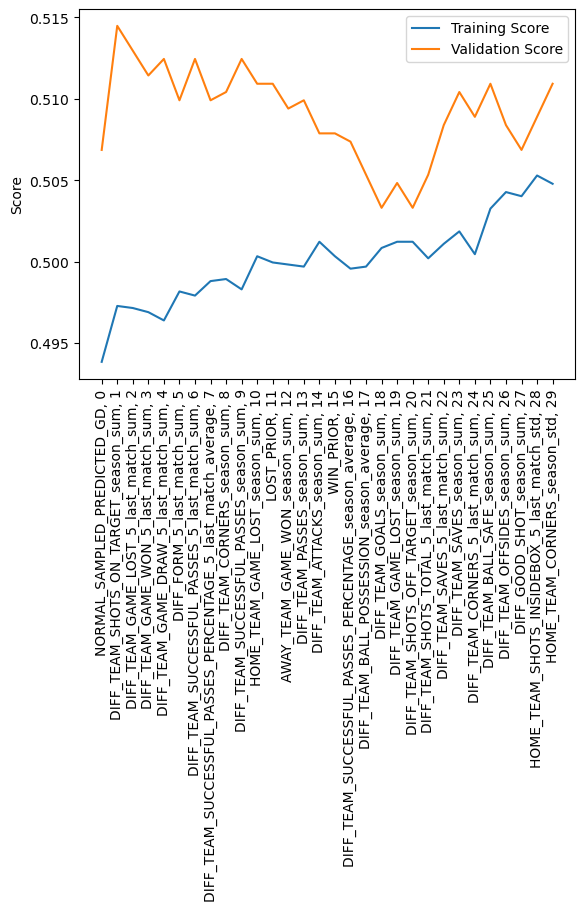

In [12]:
best_features_WL, _ = stepwise_selection(30, RidgeClassifier(), X_train_WL, y_train_WL)
stepwise_selection_plotting(best_features_WL, X_train_WL, y_train_WL, X_valid, y_valid)
# best_features_WL = pd.read_csv('goal_diff_prediction/Features.csv')['Feature'].to_list() + ['NORMAL_SAMPLED_PREDICTED_GD'] 

In [13]:
# selected_features = set()

# for pair in zip(best_features_WL, best_features_WL_upsampled):
#     if len(selected_features) > 15: # We select the top 15 from both plots as this is roughly where the 'knee'
#         break
#     selected_features.add(pair[0])
#     selected_features.add(pair[1])

print("Selected Features\n-----------------\n")
print(*best_features_WL[:25], sep = '\n') # Note that the set isn't ordered. 
selected_features = list(best_features_WL[:25])

Selected Features
-----------------

NORMAL_SAMPLED_PREDICTED_GD
DIFF_TEAM_SHOTS_ON_TARGET_season_sum
DIFF_TEAM_GAME_LOST_5_last_match_sum
DIFF_TEAM_GAME_WON_5_last_match_sum
DIFF_TEAM_GAME_DRAW_5_last_match_sum
DIFF_FORM_5_last_match_sum
DIFF_TEAM_SUCCESSFUL_PASSES_5_last_match_sum
DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average
DIFF_TEAM_CORNERS_season_sum
DIFF_TEAM_SUCCESSFUL_PASSES_season_sum
HOME_TEAM_GAME_LOST_season_sum
LOST_PRIOR
AWAY_TEAM_GAME_WON_season_sum
DIFF_TEAM_PASSES_season_sum
DIFF_TEAM_ATTACKS_season_sum
WIN_PRIOR
DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average
DIFF_TEAM_BALL_POSSESSION_season_average
DIFF_TEAM_GOALS_season_sum
DIFF_TEAM_GAME_LOST_season_sum
DIFF_TEAM_SHOTS_OFF_TARGET_season_sum
DIFF_TEAM_SHOTS_TOTAL_5_last_match_sum
DIFF_TEAM_SAVES_5_last_match_sum
DIFF_TEAM_SAVES_season_sum
DIFF_TEAM_CORNERS_5_last_match_sum


So here we have our 15 selected features. This model seems to be doing rather well. In particular
- The predicted GD is doing very well at helping to make the correct estimation
- The good shot metric is doing a good job at capturing all the shot data
- The season sum of goals doesn't appear, however I imagine this is because of the GD doing a lot of the work for this statistic.
- Oh, and the diff statistics seem to capture the information well enough. 

### Feature Selection with Wins, Losses, Draws

## Model Fitting 

### WL Fitting

In [14]:
# Some function that does cross validation 

In [15]:
# Some function that does the fitting 
def fit_WL_classifier(model_type, model_params = None, analytics = False, up_sampled = False):
    ''' Fits a model to the data give with the model_params. Then prints analytics so we get an idea of the model'''
    X, y =  (X_train_upsampled_WL[selected_features], y_train_upsampled_WL) if up_sampled else (X_train_WL[selected_features], y_train_WL)
    
    model_params = {} if model_params is None else model_params
    
    model = model_type(**model_params)
    model.fit(X, y)

    if analytics:
        show_classification_metrics(y['RESULT'], model.predict(X[selected_features]),0.75)
        show_classification_metrics(y_valid['RESULT'], model.predict(X_valid[selected_features]))
        
    return model

In [16]:
# Some function that prints the classification metrics
def show_classification_metrics(y_true, y_pred, multi = 1):
    print("Accuracy: " , np.round(multi*accuracy_score(y_true, y_pred),4))
    print("Weighted F1: ", np.round(f1_score(y_true, y_pred, average = 'weighted'),4))
    print(confusion_matrix(y_true, y_pred))

In [17]:
def find_WL_hyperparams(estimator, param_grid, up_sampled):
    '''Grid Searches for the best hyper params using CV, then return the best model fitting on the data'''
    X, y =  (X_train_upsampled_WL[selected_features], y_train_upsampled_WL) if up_sampled else (X_train_WL[selected_features], y_train_WL)
    
    clf = GridSearchCV(estimator = estimator(), param_grid=param_grid, verbose = 1)
    clf.fit(X, y)
    return clf.best_params_

#### Linear Ridge Classifier

In [18]:
RC_norm_WL_best_param = find_WL_hyperparams(RidgeClassifier, {'alpha' : np.linspace(2.6,2.7,20)}, False)
print(RC_norm_WL_best_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'alpha': 2.6}


In [19]:
print("\nNormal Sampled\n-------------")
RC_norm_WL = fit_WL_classifier(RidgeClassifier, {'alpha' : 2.64}, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Accuracy:  0.5071
Weighted F1:  0.6663
[[1182 1245]
 [ 640 2753]]
Accuracy:  0.5089
Weighted F1:  0.4269
[[286   0 290]
 [155   0 358]
 [164   0 716]]


#### LDA

In [20]:
# print("Upsampled\n---------")
# LDA_up_WL = fit_WL_classifier(LinearDiscriminantAnalysis, {}, analytics = True, up_sampled = True); 

print("\nNormal Sampled\n-------------")
LDA_norm_WL = fit_WL_classifier(LinearDiscriminantAnalysis, {}, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Accuracy:  0.508
Weighted F1:  0.6678
[[1191 1236]
 [ 642 2751]]
Accuracy:  0.5084
Weighted F1:  0.4266
[[287   0 289]
 [155   0 358]
 [166   0 714]]


#### Logistic Regression

In [21]:
LRC_norm_WL_best_param = find_WL_hyperparams(LogisticRegression, {'penalty' : ['l2'], 'C' : np.linspace(1.2,1.5, 30)}, False)
print(LRC_norm_WL_best_param)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'C': 1.2103448275862068, 'penalty': 'l2'}


In [22]:
print("\nNormal Sampled\n-------------")
LRC_norm_WL = fit_WL_classifier(LogisticRegression, {}, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Accuracy:  0.508
Weighted F1:  0.6676
[[1186 1241]
 [ 637 2756]]
Accuracy:  0.5063
Weighted F1:  0.425
[[286   0 290]
 [159   0 354]
 [169   0 711]]


#### QDA

QDA is rubbish so I removed it

#### KNN

In [23]:
# KNN_up_WL_best_param = find_WL_hyperparams(KNeighborsClassifier, {'n_neighbors' : range(1,70,5)}, True)
# print(KNN_up_WL_best_param)

KNN_norm_WL_best_param = find_WL_hyperparams(KNeighborsClassifier, {'n_neighbors' : range(145,155,1),
                                                                   'weights' : ['uniform']}, False)
print(KNN_norm_WL_best_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 154, 'weights': 'uniform'}


In [24]:
# print("Upsampled\n---------")
# KNN_up_WL = fit_WL_classifier(KNeighborsClassifier, KNN_up_WL_best_param, analytics = True, up_sampled = True); 

print("\nNormal Sampled\n-------------")
KNN_norm_WL = fit_WL_classifier(KNeighborsClassifier, {'n_neighbors': 150, 'weights': 'uniform'}, analytics = True, up_sampled = False); 


Normal Sampled
-------------
Accuracy:  0.4956
Weighted F1:  0.6457
[[1048 1379]
 [ 595 2798]]
Accuracy:  0.5028
Weighted F1:  0.4196
[[265   0 311]
 [137   0 376]
 [155   0 725]]


#### Random Forest

I can't stop this from overfitting --> DONT USE

In [25]:
# RFC_norm_WL_best_param = find_WL_hyperparams(RandomForestClassifier, {'min_samples_split' : [10000]}, False)
# RFC_norm_WL_best_param

In [26]:
# print("\nNormal Sampled\n-------------")
# RFC_norm_WL = fit_WL_classifier(RandomForestClassifier, {}, analytics = True, up_sampled = False);

#### AdaBoost 

In [27]:
ABC_norm_WL_best_param = find_WL_hyperparams(AdaBoostClassifier, {'n_estimators' : [13]}, False)
ABC_norm_WL_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'n_estimators': 13}

In [28]:
# print("Upsampled\n---------")
# ABC_up_WL = fit_WL_classifier(AdaBoostClassifier, {}, analytics = True, up_sampled = True); 

print("\nNormal Sampled\n-------------")
ABC_norm_WL = fit_WL_classifier(AdaBoostClassifier, {'n_estimators': 13}, analytics = True, up_sampled = False);


Normal Sampled
-------------
Accuracy:  0.5089
Weighted F1:  0.6711
[[1241 1186]
 [ 685 2708]]
Accuracy:  0.5084
Weighted F1:  0.4283
[[300   0 276]
 [186   0 327]
 [179   0 701]]


#### Bagging

Can't get it to stop overfitting -> don't use

In [29]:
# BC_norm_WL_best_param = find_WL_hyperparams(BaggingClassifier, {'n_estimators' : range(10,20,1)}, False)
# BC_norm_WL_best_param

In [30]:
# # print("Upsampled\n---------")
# # BC_up_WL = fit_WL_classifier(BaggingClassifier, {}, analytics = True, up_sampled = True); 

# print("\nNormal Sampled\n-------------")
# BC_norm_WL = fit_WL_classifier(BaggingClassifier, BC_norm_WL_best_param, analytics = True, up_sampled = False);

#### Gradient Boosting

In [31]:
GBC_norm_WL_best_param = find_WL_hyperparams(GradientBoostingClassifier, {'n_estimators' : [66]}, False)
GBC_norm_WL_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'n_estimators': 66}

In [32]:
# print("Upsampled\n---------")
# GBC_up_WL = fit_WL_classifier(GradientBoostingClassifier, {}, analytics = True, up_sampled = True); 

print("\nNormal Sampled\n-------------")
GBC_norm_WL = fit_WL_classifier(GradientBoostingClassifier, GBC_norm_WL_best_param, analytics = True, up_sampled = False);


Normal Sampled
-------------
Accuracy:  0.5335
Weighted F1:  0.7038
[[1314 1113]
 [ 567 2826]]
Accuracy:  0.5104
Weighted F1:  0.4287
[[289   0 287]
 [183   0 330]
 [164   0 716]]


#### NN Classifier

In [33]:
NNC_norm_WL_best_param = find_WL_hyperparams(MLPClassifier, {'hidden_layer_sizes' : [(100)],
                                                             'activation' : ['logistic'], 'early_stopping' :[True]}, False)
NNC_norm_WL_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': 100}

In [34]:
# print("Upsampled\n---------")
# NNC_up_WL = fit_WL_classifier(MLPClassifier, {}, analytics = True, up_sampled = True); 

print("\nNormal Sampled\n-------------")
NNC_norm_WL = fit_WL_classifier(MLPClassifier, NNC_norm_WL_best_param, analytics = True, up_sampled = False);


Normal Sampled
-------------
Accuracy:  0.503
Weighted F1:  0.6607
[[1168 1259]
 [ 658 2735]]
Accuracy:  0.5069
Weighted F1:  0.4256
[[288   0 288]
 [162   0 351]
 [170   0 710]]


#### Best WL Classifiers

Interestingly, the linear classifiers are doing really well.  Having said that all, apart from the NN are beating the top score in their own right, so lets put them all togther. 

In [76]:
WL_voting_clf = VotingClassifier(estimators = [
                                 # ('NNC', NNC_norm_WL), 
                                 ('GBC', GBC_norm_WL),
                                 ('ABC', ABC_norm_WL),
                                 ('KNN', KNN_norm_WL),
                                 ('LRC', LRC_norm_WL), 
                                 ('LDA', LDA_norm_WL),
                                 # ('RC', RC_norm_WL) # We have to ignore this as we are using voting = 'soft'
                                ],
                                voting = 'hard')
WL_voting_clf.fit(X_train_WL[selected_features], y_train_WL)  
show_classification_metrics(y_train_WL['RESULT'], WL_voting_clf.predict(X_train_WL[selected_features]),0.75)
show_classification_metrics(y_valid['RESULT'], WL_voting_clf.predict(X_valid[selected_features]))
                                 
                                 

Accuracy:  0.5151
Weighted F1:  0.6768
[[1203 1224]
 [ 599 2794]]
Accuracy:  0.5069
Weighted F1:  0.4253
[[285   0 291]
 [161   0 352]
 [167   0 713]]


So this classifier seems to be working rather well! Now lets try and predict WDL

### WDL Classification 

In [36]:
def fit_WLD_classifier(model_type, model_params = None, OvR = True):
    ''' Fits a model to the data give with the model_params. Then prints analytics so we get an idea of the model'''
    X, y =  (X_train[selected_features], y_train)
    
    model_params = {} if model_params is None else model_params
    
    model = OneVsRestClassifier(model_type(**model_params)) if OvR else OneVsOneClassifier(model_type(**model_params))
    model.fit(X, y)

   
    show_classification_metrics(y['RESULT'], model.predict(X[selected_features]))
    show_classification_metrics(y_valid['RESULT'], model.predict(X_valid[selected_features]))
        
    return model

In [37]:
def get_classifier_dict(grid_search_dict): # This will remove the estimator__ predix
    return {k[11:] : v for k, v in grid_search_dict.items()}

In [38]:
def find_WLD_hyperparams(estimator, param_grid):
    '''Grid Searches for the best hyper params using CV, then return the best model fitting on the data'''
    X, y =  (X_train[selected_features], y_train)
    
    clf = GridSearchCV(estimator = OneVsRestClassifier(estimator()), param_grid=param_grid, verbose = 1)
    clf.fit(X, y)
    return get_classifier_dict(clf.best_params_)

#### Ridge Classifier

In [39]:
RC_norm_WLD_best_param = find_WLD_hyperparams(RidgeClassifier, {'estimator__alpha' : np.linspace(1,1.7,20)})
print(RC_norm_WLD_best_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'alpha': 1.0}


In [40]:
print("\nNormal Sampled\n-------------")
RC_norm_WLD = fit_WLD_classifier(RidgeClassifier, RC_norm_WLD_best_param); 


Normal Sampled
-------------
Accuracy:  0.5021
Weighted F1:  0.4227
[[1204    6 1217]
 [ 680    7 1366]
 [ 642    9 2742]]
Accuracy:  0.5094
Weighted F1:  0.4279
[[289   0 287]
 [156   0 357]
 [164   2 714]]


#### LDA

In [41]:
print("\nNormal Sampled\n-------------")
LDA_norm_WLD = fit_WLD_classifier(LinearDiscriminantAnalysis, {});


Normal Sampled
-------------
Accuracy:  0.502
Weighted F1:  0.4256
[[1197   20 1210]
 [ 676   21 1356]
 [ 642   17 2734]]
Accuracy:  0.5069
Weighted F1:  0.428
[[286   4 286]
 [155   2 356]
 [164   6 710]]


#### KNN

In [42]:
KNN_norm_WLD_best_param = find_WLD_hyperparams(KNeighborsClassifier, {'estimator__n_neighbors' : range(60,70, 1)})
print(KNN_norm_WLD_best_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 60}


In [43]:
print("\nNormal Sampled\n-------------")
KNN_norm_WLD = fit_WLD_classifier(KNeighborsClassifier, KNN_norm_WLD_best_param); 


Normal Sampled
-------------
Accuracy:  0.4998
Weighted F1:  0.4476
[[1039  130 1258]
 [ 513  179 1361]
 [ 527  149 2717]]
Accuracy:  0.5074
Weighted F1:  0.4541
[[255  38 283]
 [140  42 331]
 [149  29 702]]


#### Adaboost 

In [44]:
ABC_norm_WLD_best_param = find_WLD_hyperparams(AdaBoostClassifier, {'estimator__n_estimators' : range(0,6)})
print(ABC_norm_WLD_best_param)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'n_estimators': 1}


In [45]:
print("\nNormal Sampled\n-------------")
ABC_norm_WLD = fit_WLD_classifier(AdaBoostClassifier, ABC_norm_WLD_best_param); 


Normal Sampled
-------------
Accuracy:  0.4885
Weighted F1:  0.3922
[[ 761    0 1666]
 [ 310    0 1743]
 [ 308    0 3085]]
Accuracy:  0.5084
Weighted F1:  0.4119
[[197   0 379]
 [ 88   0 425]
 [ 76   0 804]]


#### Gradient Boosting

In [46]:
GBC_norm_WLD_best_param = find_WLD_hyperparams(GradientBoostingClassifier, {'estimator__n_estimators' : range(35,40, 1)})
print(GBC_norm_WLD_best_param)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_estimators': 38}


In [47]:
print("\nNormal Sampled\n-------------")
GBC_norm_WLD = fit_WLD_classifier(GradientBoostingClassifier, GBC_norm_WLD_best_param);


Normal Sampled
-------------
Accuracy:  0.5194
Weighted F1:  0.4456
[[1236   11 1180]
 [ 632   55 1366]
 [ 586    9 2798]]
Accuracy:  0.5135
Weighted F1:  0.4371
[[286   8 282]
 [160   7 346]
 [157   5 718]]


#### NN 

In [48]:
NNC_norm_WLD_best_param = find_WLD_hyperparams(MLPClassifier, {'estimator__hidden_layer_sizes' : [(100)],
                                                             'estimator__activation' : ['logistic'], 'estimator__early_stopping' :[True]})
NNC_norm_WLD_best_param

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': 100}

In [49]:
NNC_norm_WLD = fit_WLD_classifier(MLPClassifier, NNC_norm_WLD_best_param);

Accuracy:  0.4914
Weighted F1:  0.4114
[[1156    0 1271]
 [ 650    0 1403]
 [ 680    0 2713]]
Accuracy:  0.5038
Weighted F1:  0.4234
[[289   0 287]
 [165   0 348]
 [177   0 703]]


#### WLD Conclusions

There seems to be no real improvement over using the WL classifier, therefore we will only use that. 

## Testing and Saving WL Classifier

To check that we haven't done any silly overfitting, we can print the scores on each of the training, validation and test data set.

In [77]:
print("Training Scores\n---------------")
show_classification_metrics(y_train_WL['RESULT'], WL_voting_clf.predict(X_train_WL[selected_features]),0.75)

print("\nValidation Scores\n-----------------")
show_classification_metrics(y_valid['RESULT'], WL_voting_clf.predict(X_valid[selected_features]))

print("\nTesting Scores\n--------------")
show_classification_metrics(y_test['RESULT'], WL_voting_clf.predict(X_test[selected_features]))

Training Scores
---------------
Accuracy:  0.5151
Weighted F1:  0.6768
[[1203 1224]
 [ 599 2794]]

Validation Scores
-----------------
Accuracy:  0.5069
Weighted F1:  0.4253
[[285   0 291]
 [161   0 352]
 [167   0 713]]

Testing Scores
--------------
Accuracy:  0.5063
Weighted F1:  0.4262
[[361   0 397]
 [173   0 447]
 [198   0 885]]


i.e. we seem to be doing pretty well! I guess we should now go ahead and train this model

In [86]:
with open('WL_Model/WL_prediction.pkl', 'wb') as f:
    pickle.dump(WL_voting_clf, f)

In [87]:
features = pd.DataFrame({'Features' : selected_features})
features.to_csv("WL_Model/WL_model_features.csv")